# Task - Images from Google Disk
- Add noise to any images loaded from disk
- Build and train an autoencoder whose purpose is to remove noise from images
- Visualize how the autoencoder works - shows the noised and cleared image

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

import keras.utils as image
import os

Helper functions

In [2]:
def plot_mnist(images1, labels1 = None, images2 = None, labels2 = None,n=10):
    """ 
    Plots n images in a row with their labels. Can plot two rows of images.
    Args:
        images1 (np.array): array of images
        labels1 (list, optional): labels for images1. Defaults to None.
        images2 (np.array, optional): array of images in the second row. Defaults to None.
        labels2 (list, optional): labels for images2. Defaults to None.
        n (int, optional): number of images to plot. Defaults to 10.
    """
    plt.figure(figsize=(2*n, 4))
    if images2 is None:
        nr_rows = 1
    else:
        nr_rows = 2
    for i in range(n):
    # display original
        ax = plt.subplot(nr_rows, n, i + 1)
        img = images1[i]
        if len(img.shape) > 2:
            img = tf.squeeze(img)
        plt.imshow(img)
        if labels1 is not None:
            plt.title(labels1[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if images2 is not None:
    # display reconstruction
            ax = plt.subplot(nr_rows, n, i + 1 + n)
            img = images2[i]
            if len(img.shape) > 2:
                img = tf.squeeze(img)
            plt.imshow(img)
            if labels2 is not None:
                plt.title(labels2[i])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

def plot_history(history):
    """
    Plots the loss and accuracy of the model.
    Args:
        history (keras.callbacks.History): Model.fit output
    """
    plt.figure()
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

## Part 1 - Basic autoencoder
Let's build a basic autoencoder based on the presented schema. To define your model, we will use the [Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models).

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
images_train = []
for img in os.listdir(f'/content/drive/MyDrive/LMAD/TransferLearning/data/train/minion'):
    img = image.load_img(f'/content/drive/MyDrive/LMAD/TransferLearning/data/train/minion/{img}', target_size=(512,512))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images_train.append(img[0])

x_train = np.array(images_train)
x_train = x_train.astype('float32')/255.
x_train.shape

(224, 512, 512, 3)

In [5]:
images_test = []
for img in os.listdir(f'/content/drive/MyDrive/LMAD/TransferLearning/data/test/minion'):
    img = image.load_img(f'/content/drive/MyDrive/LMAD/TransferLearning/data/test/minion/{img}', target_size=(512,512))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images_test.append(img[0])

x_test = np.array(images_test)
x_test = x_test.astype('float32')/255.
x_test.shape

(41, 512, 512, 3)

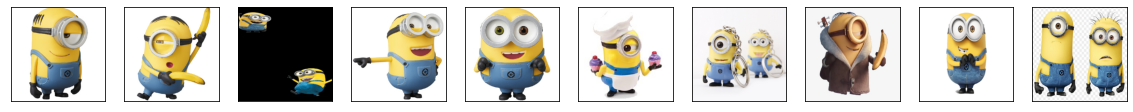

In [6]:
plot_mnist(x_test)

## Part 2 - Dealing with noisy images
This time we will:
- add noise to test images
- build a convolutional autoencoder 
- use this autoencoder to denoise images.


#### Adding noise to images
Let's add Gausian nosie to our datasets 

In [7]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 
x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.) #przycinanie w przypadku gdy wartości są spoza przedziału (0,1)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

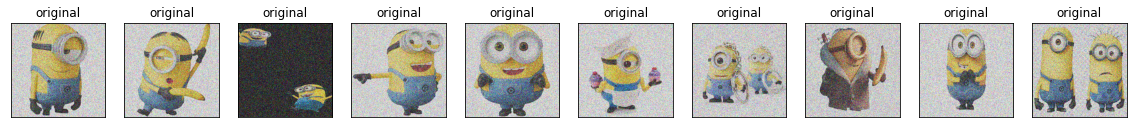

In [8]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

#### Autoencoder for denoisification





In [9]:
class Denoise(Model):
    def __init__(self):
        super().__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(512, 512, 3)), #warstwa początkowa
            layers.Conv2D(32, 3, activation='relu', padding='same', strides=2),
            layers.Conv2D(16, 3, activation='relu', padding='same', strides=2), #za każdym razem okno zmienia się o 2, czyli z 28 ---> 14 # kurczy obrazki
            layers.Conv2D(8, 3, activation='relu', padding='same', strides=2) # stride: z 14 ---> 7
        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'), #rozszerza obrazki, strides: robi się obrazek 2 razy większy 
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'), #16 - liczba kanałów/filtrów, kernel_size- rozmiar okna konwolucji
            layers.Conv2DTranspose(32, 3, activation='relu', padding='same', strides=2),
            layers.Conv2D(3, kernel_size=3, activation='sigmoid', padding='same')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Epoch 1/100
7/7 [==============================] - 15s 631ms/step - loss: 0.1525 - val_loss: 0.1660
Epoch 2/100
7/7 [==============================] - 3s 492ms/step - loss: 0.1418 - val_loss: 0.1378
Epoch 3/100
7/7 [==============================] - 4s 517ms/step - loss: 0.1081 - val_loss: 0.0850
Epoch 4/100
7/7 [==============================] - 3s 500ms/step - loss: 0.0919 - val_loss: 0.0830
Epoch 5/100
7/7 [==============================] - 3s 502ms/step - loss: 0.0858 - val_loss: 0.0779
Epoch 6/100
7/7 [==============================] - 3s 500ms/step - loss: 0.0804 - val_loss: 0.0734
Epoch 7/100
7/7 [==============================] - 3s 506ms/step - loss: 0.0737 - val_loss: 0.0643
Epoch 8/100
7/7 [==============================] - 3s 503ms/step - loss: 0.0639 - val_loss: 0.0547
Epoch 9/100
7/7 [==============================] - 4s 516ms/step - loss: 0.0535 - val_loss: 0.0463
Epoch 10/100
7/7 [==============================] - 4s 517ms/step - loss: 0.0465 - val_loss: 0.0419
Epoch 11

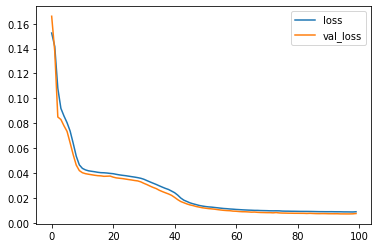

In [10]:
autoencoder = Denoise()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
history = autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))
plot_history(history)


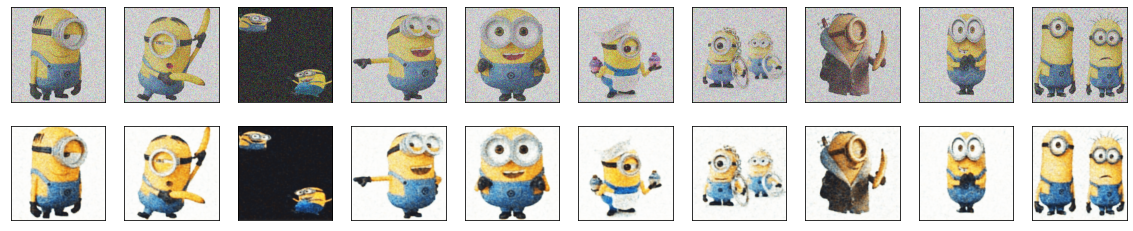

In [11]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
plot_mnist(x_test_noisy, images2 = decoded_imgs)

In [12]:
def prepareImg(path_name):
  path = "/content/drive/MyDrive/LMAD/TransferLearning/data/noise/"
  file = path + path_name

  img = tf.keras.preprocessing.image.load_img(file, target_size=(512,512))
  img=[tf.keras.preprocessing.image.img_to_array(img)]
  return img

In [13]:
img_t=prepareImg('noise.jpg')
img_t = np.array(img_t)
img = img_t.astype('float32')/255.
img.shape

(1, 512, 512, 3)

In [14]:
def PredPlot(img1,img2):
  fig = plt.figure(figsize=(20, 6))
  ax1 = fig.add_subplot(1,2,1)
  ax2 = fig.add_subplot(1,2,2)
  ax1.imshow(img1[0])
  ax2.imshow(img2[0])

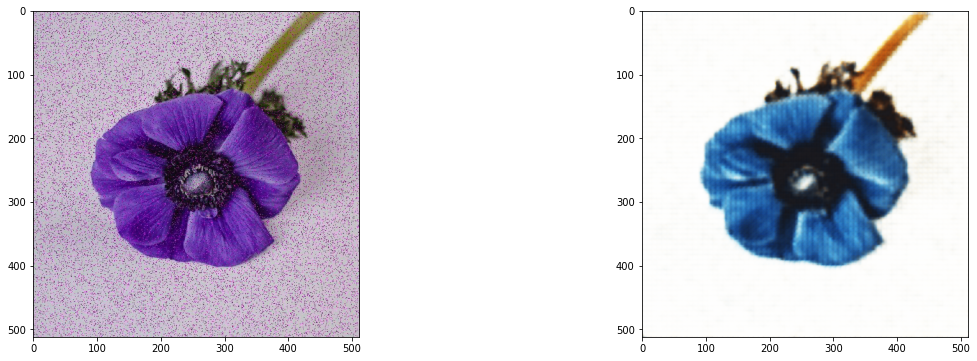

In [15]:

encoded_img = autoencoder.encoder(img).numpy()
decoded_img = autoencoder.decoder(encoded_img).numpy()
PredPlot(img, decoded_img)

In [16]:
class Denoise2(Model):
    def __init__(self):
        super().__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(512, 512, 3)), #warstwa początkowa
            layers.Conv2D(52, 9, activation='relu', padding='same', strides=2),
            layers.Conv2D(16, 3, activation='relu', padding='same', strides=2), #za każdym razem okno zmienia się o 2, czyli z 28 ---> 14 # kurczy obrazki
            layers.Conv2D(16, 3, activation='relu', padding='same', strides=1) # stride: z 14 ---> 7
        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(16, kernel_size=3, strides=1, activation='relu', padding='same'), #rozszerza obrazki, strides: robi się obrazek 2 razy większy 
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'), #16 - liczba kanałów/filtrów, kernel_size- rozmiar okna konwolucji
            layers.Conv2DTranspose(52, 9, activation='relu', padding='same', strides=2),
            layers.Conv2D(3, kernel_size=3, activation='sigmoid', padding='same')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Epoch 1/50
7/7 [==============================] - 19s 1s/step - loss: 0.1138 - val_loss: 0.0847
Epoch 2/50
7/7 [==============================] - 7s 1s/step - loss: 0.0875 - val_loss: 0.0783
Epoch 3/50
7/7 [==============================] - 7s 1s/step - loss: 0.0827 - val_loss: 0.0814
Epoch 4/50
7/7 [==============================] - 7s 1s/step - loss: 0.0812 - val_loss: 0.0736
Epoch 5/50
7/7 [==============================] - 7s 1s/step - loss: 0.0782 - val_loss: 0.0720
Epoch 6/50
7/7 [==============================] - 7s 1s/step - loss: 0.0750 - val_loss: 0.0672
Epoch 7/50
7/7 [==============================] - 7s 1s/step - loss: 0.0711 - val_loss: 0.0623
Epoch 8/50
7/7 [==============================] - 7s 1s/step - loss: 0.0632 - val_loss: 0.0599
Epoch 9/50
7/7 [==============================] - 7s 1s/step - loss: 0.0534 - val_loss: 0.0432
Epoch 10/50
7/7 [==============================] - 7s 1s/step - loss: 0.0456 - val_loss: 0.0479
Epoch 11/50
7/7 [==============================]

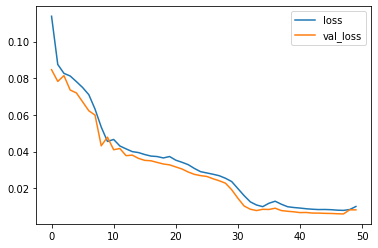

In [17]:
autoencoder2 = Denoise2()
autoencoder2.compile(optimizer='adam', loss=losses.MeanSquaredError())
history = autoencoder2.fit(x_train_noisy, x_train,
                epochs=50,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))
plot_history(history)

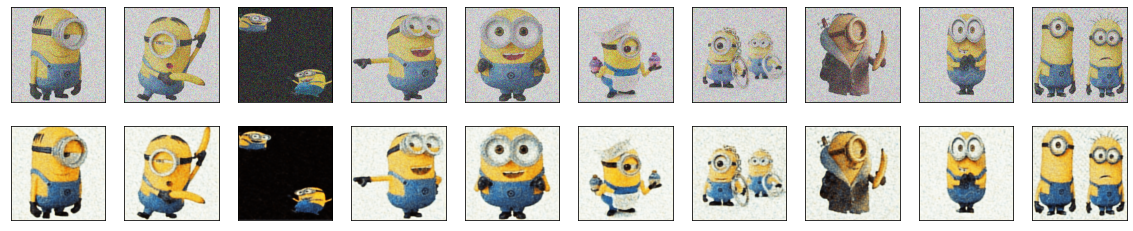

In [18]:
encoded_imgs = autoencoder2.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder2.decoder(encoded_imgs).numpy()
plot_mnist(x_test_noisy, images2 = decoded_imgs)

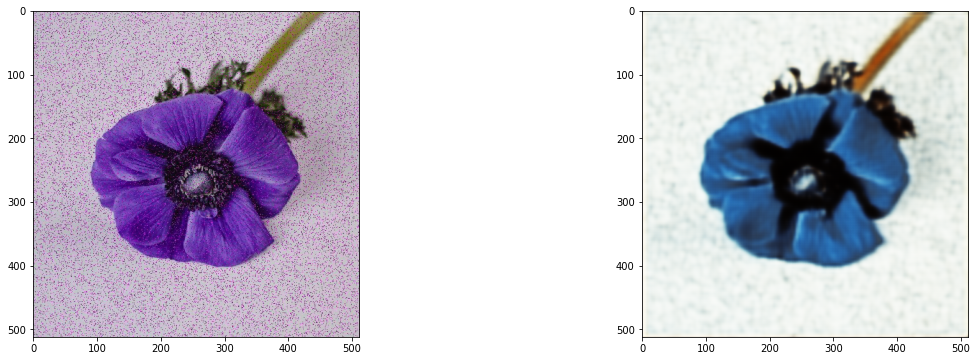

In [19]:
encoded_img = autoencoder2.encoder(img).numpy()
decoded_img = autoencoder2.decoder(encoded_img).numpy()
PredPlot(img, decoded_img)